# Presentation

## Overview

For this project, I analyzed a restaurant and consumer dataset via statistical modeling and machine learning to determine if the data from a consumer profile is sufficient enough to determine the consumer's rating of a specific restaurant. If a restaurant is able to know how much a consumer will like their restaurant before they even enter it, they will then know what they need to improve on to better their customer satisfaction. The end product of this project is a customer satisfaction prediction tool.

## Imports

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import seaborn as sns
import sklearn as sk
import sklearn.naive_bayes as nb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

## The Dataset

There are multiple tables of data we will be using to build our customer satisfaction prediction tool
- The user_profile table includes attributes of individual consumers
- The user_cuisine table shows types of cuisines that are preferred by individual users
- The restaurant_profile table includes attributes of individual restaurants
- The restaurant_cuisine table shows types of cuisines individual restaurants are associated with
- The ratings table shows user ratings of restaurants

In [2]:
user_profile = pd.read_csv('/data/StefanBonilla/userprofile.csv', encoding='unicode_escape')
user_cuisine = pd.read_csv('/data/StefanBonilla/usercuisine.csv', encoding='unicode_escape')
restaurant_profile = pd.read_csv('/data/StefanBonilla/geoplaces2.csv', encoding='unicode_escape')
restaurant_cuisine = pd.read_csv('/data/StefanBonilla/chefmozcuisine.csv', encoding='unicode_escape')
ratings = pd.read_csv('/data/StefanBonilla/rating_final.csv', encoding='unicode_escape')

In [3]:
user_profile.columns

Index(['userID', 'latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
       'birth_year', 'interest', 'personality', 'religion', 'activity',
       'color', 'weight', 'budget', 'height'],
      dtype='object')

In [4]:
restaurant_profile.columns

Index(['placeID', 'latitude', 'longitude', 'the_geom_meter', 'name', 'address',
       'city', 'state', 'country', 'fax', 'zip', 'alcohol', 'smoking_area',
       'dress_code', 'accessibility', 'price', 'url', 'Rambience', 'franchise',
       'area', 'other_services'],
      dtype='object')

The target attribute for this project is the `rating` attribute of the `ratings` table. This represents a consumer's overall rating of a restaurant

In [13]:
ratings.columns

Index(['userID', 'placeID', 'rating', 'food_rating', 'service_rating'], dtype='object')

## Exploratory Analysis and Cleaning

In [6]:
mergedTable = pd.read_pickle('user_restaurant_ratings_exploration')
list(mergedTable.columns)

['userID',
 'latitude_x',
 'longitude_x',
 'smoker',
 'drink_level',
 'dress_preference',
 'ambience',
 'marital_status',
 'hijos',
 'birth_year',
 'interest',
 'personality',
 'religion',
 'activity',
 'color',
 'weight',
 'budget',
 'height',
 'u_Afghan',
 'u_African',
 'u_American',
 'u_Armenian',
 'u_Asian',
 'u_Australian',
 'u_Austrian',
 'u_Bagels',
 'u_Bakery',
 'u_Bar',
 'u_Bar_Pub_Brewery',
 'u_Barbecue',
 'u_Basque',
 'u_Brazilian',
 'u_Breakfast-Brunch',
 'u_British',
 'u_Burgers',
 'u_Burmese',
 'u_Cafe-Coffee_Shop',
 'u_Cafeteria',
 'u_Cajun-Creole',
 'u_California',
 'u_Cambodian',
 'u_Canadian',
 'u_Caribbean',
 'u_Chilean',
 'u_Chinese',
 'u_Contemporary',
 'u_Continental-European',
 'u_Cuban',
 'u_Deli-Sandwiches',
 'u_Dessert-Ice_Cream',
 'u_Dim_Sum',
 'u_Diner',
 'u_Doughnuts',
 'u_Dutch-Belgian',
 'u_Eastern_European',
 'u_Eclectic',
 'u_Ethiopian',
 'u_Family',
 'u_Fast_Food',
 'u_Filipino',
 'u_Fine_Dining',
 'u_French',
 'u_Fusion',
 'u_Game',
 'u_German',
 'u_G

Realized there are too many columns in the merged dataset, needed to cut it down to make more accurate predictions
- Dropped all location related data. Determined that a customer can either be satisfied or unsatisfied by any restaurant in the world
- Dropped all cuisine related data. Realized that just because a consumer's favorite cuisine is served by a restaurant doesn't necessarily mean that the consumer will give the restaurant a high or low rating.
- Also dropped other unnecessary attributes such as `favorite color`, `religion`, and `marital_status` since they didn't seem to correlate with overall restaurant ratings

The attributes that had the highest correlations to rating via `RandomForestClassifier` feature importances were:

Consumers:
- height
- weight
- birth_year
- drink_level [abstemious,social drinker,casual drinker]
- smoker [True, False]
- dress_preference [informal,formal,no preference,elegant]
- ambience [family,friends,solitary]
- interest [variety,technology,none,retro,eco-friendly]
- personality [thrifty-protector,hunter-ostentatious,hard-worker,conformist]
- activity [student,professional,unemployed,working-class]
- budget [medium,low,high]

Restaurants:
- alcohol [No_Alcohol_Served,Wine_Beer,Full_Bar]
- smoking_area [none,only_at_bar,permitted,section,not_permitted]
- dress_code [informal,casual,formal]
- price [medium,low,high]
- ambience [familiar,quiet]
- area [open,closed]
- franchise [True, False]

In [7]:
finalTable = pd.read_pickle('user_restaurant_ratings_modeling')
finalTable.head()

,smoker,birth_year,weight,height,rating,franchise,abstemious,casual drinker,social drinker,elegant,...,casual,formal,informal,high,low,medium,familiar,quiet,closed,open
0,False,1989,69,1.77,2,False,1,0,0,0,...,0,0,1,0,1,0,1,0,0,1
1,False,1990,40,1.87,2,False,1,0,0,0,...,0,0,1,0,1,0,1,0,0,1
2,False,1989,60,1.69,2,False,0,0,1,0,...,0,0,1,0,1,0,1,0,0,1
3,True,1989,75,1.80,1,False,0,0,1,0,...,0,0,1,0,1,0,1,0,0,1
4,False,1991,75,1.78,1,False,1,0,0,0,...,0,0,1,0,1,0,1,0,0,1


## Machine Learning

### Train/Test split

In [8]:
user_restaurant_ratings = pd.read_pickle('user_restaurant_ratings_modeling')
X = user_restaurant_ratings.drop('rating', axis=1)
y = user_restaurant_ratings.rating
Xtrain, Xtest, ytrain, ytest = sk.cross_validation.train_test_split(X, y)

### Logistic Regression

Perform the following steps with the `sklearn.linear_model.LogisticRegression` classifier:

1. Instantiate the model class
2. Fit the model with the training data
3. Use the model to make predictions about the test data

In [9]:
clf_logreg = LogisticRegression()
clf_logreg.fit(Xtrain, ytrain)
prediction_logreg = clf_logreg.predict(Xtest)
clf_logreg.score(Xtest, ytest)

0.55251141552511418

[[18 23 17]
 [ 3 44 32]
 [ 1 22 59]]


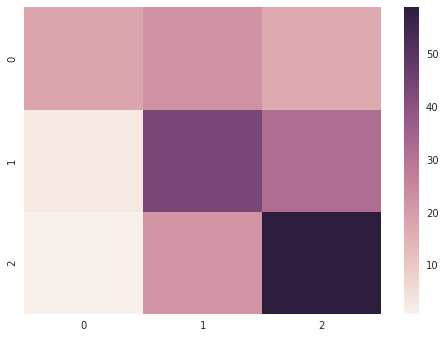

In [10]:
print(confusion_matrix(ytest, prediction_logreg))
sns.heatmap(confusion_matrix(ytest, prediction_logreg));

### The Customer Satisfaction Prediction Tool

Plug in a consumer profile and a restaurant profile to predict customer satisfaction! Consumer attributes are prefixed `u_`. Restaurant attributes are prefixed `r_`.

Rating System:
* 0 - poor
* 1 - average
* 2 - great

In [18]:
test = X.loc[0]
def customer_satisfaction_prediction(u_height, u_weight, u_smoker=0, u_drink_level=0, 
                                     u_dress_preference=0, u_ambience=0, u_birth_year=0, 
                                     u_interest=0, u_personality=0, u_activity=0, 
                                     u_budget=0, r_alcohol=0,
                                     r_smoking_area=0, r_dress_code=0, r_price=0, 
                                     r_ambience=0, r_franchise=0, r_area=0):
    for i in test.keys():
        test[i] = 0
    test['height'] = u_height
    test['weight'] = u_weight
    test['smoker'] = u_smoker
    test[u_drink_level] = 1
    test[u_dress_preference] = 1
    test[u_ambience] = 1
    test['birth_year'] = u_birth_year
    test[u_interest] = 1
    test[u_personality] = 1
    test[u_activity] = 1
    test[u_budget] = 1
    test[r_alcohol] = 1
    test[r_smoking_area] = 1
    test[r_dress_code] = 1
    test[r_price] = 1
    test[r_ambience] = 1
    test['franchise'] = r_franchise
    return 'Rating: ' + str(clf_logreg.predict(test.reshape(1,-1))[0])

In [19]:
interact(customer_satisfaction_prediction, 
         u_height=(0, 3, .1), u_weight=(0, 150, 1), u_smoker=True, 
         u_drink_level=['abstemious','social drinker','casual drinker'],
         u_dress_preference=['informal','formal','no preference','elegant'],
         u_ambience=['family','friends','solitary'],
         u_birth_year=(1900, 2015, 1),
         u_interest=['variety','technology','none','retro','eco-friendly'],
         u_personality=['thrifty-protector','hunter-ostentatious','hard-worker','conformist'],
         u_activity=['student','professional','unemployed','working-class'],
         u_budget=['medium','low','high'],
         r_alcohol=['No_Alcohol_Served','Wine_Beer','Full_Bar'],
         r_smoking_area=['none','only_at_bar','permitted','section','not_permitted'],
         r_dress_code=['informal','casual','formal'],
         r_price=['medium','low','high'],
         r_ambience=['familiar','quiet'],
         r_franchise=True,
         r_area=['open', 'closed'], __manual=True)

'Rating: 2'

## Sources

1. Medellan, Rafael Ponce, and Juan Gabriel Gonzalez. "Restaurant & Consumer Data Data Set." UCI Machine Learning Repository. N.p., n.d. Web. 3 Mar. 2016. <https://archive.ics.uci.edu/ml/datasets/Restaurant+%26+consumer+data>.